In [1]:
#0: imports

import uproot 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from dataAnalyse import CCV1
from torch_geometric.data import DataLoader 
from models import Net_SEC, Net_GAT, Net_SECGAT, Net_Trans, Net_split
from torch_geometric.nn import knn_graph

import numpy as np
import time

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [2]:
#1: Load Data + Model
#1.1: Load Data Through the dataloader - used for predictions
#testpath = "/vols/cms/mm1221/Data/mix/test/"  
testpath = "/vols/cms/mm1221/Data/100k/5pi/test/"
data_test = CCV1(testpath, max_events=15000, inp = 'test')
test_loader = DataLoader(data_test, batch_size=1, shuffle=False, follow_batch=['x'])


### Loading tracksters data


  0%|                                                     | 0/1 [00:00<?, ?it/s]

/vols/cms/mm1221/Data/100k/5pi/test/raw/test.root


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.19s/it]
/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [3]:
# Also load explicitely, used for analysis and plots
#data_path = '/vols/cms/mm1221/Data/mix/test/raw/test.root'
data_path = '/vols/cms/mm1221/Data/100k/5pi/test/raw/test.root' 
data_file = uproot.open(data_path)

ass = data_file['associations']['tsCLUE3D_recoToSim_CP'].array()
print("...")
scores = data_file['associations']['tsCLUE3D_recoToSim_CP_score'].array()
Track_ind = data_file['tracksters']['vertices_indexes'].array()
print('.')
GT_ind = data_file['simtrackstersCP']['vertices_indexes'].array()
GT_mult = data_file['simtrackstersCP']['vertices_multiplicity'].array()
GT_bc = data_file['simtrackstersCP']['barycenter_x'].array()
energies = data_file['clusters']['energy'].array()
print("...")
LC_x = data_file['clusters']['position_x'].array()
LC_y = data_file['clusters']['position_y'].array()
LC_z = data_file['clusters']['position_z'].array()
print('..')
LC_eta = data_file['clusters']['position_eta'].array()
MT_ind = data_file['trackstersMerged']['vertices_indexes'].array()
print("...")


#1.3 Filter so get rid of events with 0 calo particles
t_bx = data_file['tracksters']['barycenter_x'].array()
print("...")

skim_mask = []
for e in t_bx:
    if len(e) == 0:
        skim_mask.append(False)
    else:
        skim_mask.append(True)

Track_ind = Track_ind[skim_mask]
GT_ind = GT_ind[skim_mask]
GT_mult = GT_mult[skim_mask]
energies = energies[skim_mask]
LC_x = LC_x[skim_mask]
LC_y = LC_y[skim_mask]
LC_z = LC_z[skim_mask]
LC_eta = LC_eta[skim_mask]
MT_ind = MT_ind[skim_mask]
ass = ass[skim_mask]
scores=scores[skim_mask]





...
.
...
..
...
...


In [4]:
MT_mult = data_file['trackstersMerged']['vertices_multiplicity'].array()

In [5]:
pgid = data_file['simtrackstersCP']['pdgID'].array()
reg_en = data_file['simtrackstersCP']['regressed_energy'].array()
MT_mult = data_file['trackstersMerged']['vertices_multiplicity'].array()
skim_mask = []
for e in t_bx:
    if len(e) == 0:
        skim_mask.append(False)
    else:
        skim_mask.append(True)
        
pgid = pgid[skim_mask]
reg_en = reg_en[skim_mask]
MT_mult = MT_mult[skim_mask]

In [6]:
import awkward as ak

def filter_repeated_indexes(GT_ind, GT_mult):
    """
    Given:
       - GT_ind: an awkward array (or list of lists) of indexes for one event.
       - GT_mult: an awkward array (or list of lists) of multiplicity values (same shape as GT_ind).
    
    For any index that appears in more than one sub-array, keep only the occurrence with the
    smallest multiplicity, and set that multiplicity to 1.0. All other occurrences are removed.
    
    Returns:
       new_GT_ind, new_GT_mult  
         Both are returned as <class 'awkward.highlevel.Array'>.
    """
    # 1. Record all occurrences of each index.
    occurrences = {}
    for sub_i, (sub_ind, sub_mult) in enumerate(zip(GT_ind, GT_mult)):
        for pos, (val, mult) in enumerate(zip(sub_ind, sub_mult)):
            occurrences.setdefault(val, []).append((sub_i, pos, mult))
    
    # 2. Mark occurrences to remove and those to update.
    removals = set()
    update_to_one = set()
    
    for index_val, occ_list in occurrences.items():
        if len(occ_list) > 1:
            occ_list_sorted = sorted(occ_list, key=lambda x: x[2])  # Sort by multiplicity
            kept_occ = occ_list_sorted[0]  # Keep lowest multiplicity
            update_to_one.add((kept_occ[0], kept_occ[1]))
            for occ in occ_list_sorted[1:]:
                removals.add((occ[0], occ[1]))
    
    # 3. Reconstruct new GT_ind and GT_mult by filtering out the removals.
    new_GT_ind = []
    new_GT_mult = []
    for sub_i, (sub_ind, sub_mult) in enumerate(zip(GT_ind, GT_mult)):
        new_sub_ind = []
        new_sub_mult = []
        for pos, (val, mult) in enumerate(zip(sub_ind, sub_mult)):
            if (sub_i, pos) in removals:
                continue
            new_sub_ind.append(val)
            new_sub_mult.append(1.0 if (sub_i, pos) in update_to_one else mult)
        new_GT_ind.append(new_sub_ind)
        new_GT_mult.append(new_sub_mult)
    
    # Convert lists to awkward arrays
    return ak.Array(new_GT_ind), ak.Array(new_GT_mult)

def filter_repeated_indexes_for_events(all_GT_ind, all_GT_mult):
    """
    Given a list of events, each with its GT_ind and GT_mult (lists of sub-arrays),
    apply filter_repeated_indexes to each event.
    
    Args:
        all_GT_ind: List of events. Each event is an awkward array (or list of sub-arrays) of indexes.
        all_GT_mult: List of events. Each event is an awkward array (or list of sub-arrays) of multiplicity values.
    
    Returns:
        new_all_GT_ind, new_all_GT_mult: Awkward arrays (one per event) of filtered GT_ind and GT_mult.
    """
    new_all_GT_ind = []
    new_all_GT_mult = []
    
    # Loop over each event
    for event_ind, event_mult in zip(all_GT_ind, all_GT_mult):
        new_event_ind, new_event_mult = filter_repeated_indexes(event_ind, event_mult)
        new_all_GT_ind.append(new_event_ind)
        new_all_GT_mult.append(new_event_mult)
    
    # Convert to awkward arrays
    return ak.Array(new_all_GT_ind), ak.Array(new_all_GT_mult)


In [7]:
GT_ind, GT_mult = filter_repeated_indexes_for_events(GT_ind, GT_mult)

In [125]:
sums = 0
for i in range(len(MT_ind[474])):
    add = len(MT_ind[474][i])
    sums += add
print(sums)

869


In [8]:

# load the model 
#model = Net(
    #hidden_dim=128,
    #num_layers=4,
    #dropout=0.3,
    #contrastive_dim=16
#)
model = Net_SEC(
    hidden_dim=256,num_layers=3, dropout=0.3, contrastive_dim=512
)
checkpoint= torch.load('/vols/cms/mm1221/hgcal/Mixed/Track/NegativeMining/runs/SECNEW/hd256nl3cd512k64/epoch-125.pt',  map_location=torch.device('cpu'))
#checkpoint= torch.load('/vols/cms/mm1221/hgcal/Mixed/Track/Cluster/runs2/best_model.pt',  map_location=torch.device('cpu'))
#checkpoint= torch.load('/vols/cms/mm1221/hgcal/elec5New/Track/NegativeMining/resultsSECNeg/epoch-228.pt',  map_location=torch.device('cpu'))
#checkpoint= torch.load('/vols/cms/mm1221/hgcal/pion5New/Track/NegativeMining/resultsSECNeg/best_model.pt',  map_location=torch.device('cpu'))

model.load_state_dict(checkpoint['model'])  
model.eval()  



Net_SEC(
  (lc_encode): Sequential(
    (0): Linear(in_features=16, out_features=256, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ELU(alpha=1.0)
  )
  (convs): ModuleList(
    (0-2): 3 x CustomStaticEdgeConv(
      (nn_module): Sequential(
        (0): Linear(in_features=512, out_features=256, bias=True)
        (1): ELU(alpha=1.0)
        (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Dropout(p=0.3, inplace=False)
      )
    )
  )
  (output): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): ELU(alpha=1.0)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ELU(alpha=1.0)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=32, out_features=512, bias=True)
  )
)

In [9]:
import awkward as ak

# Create new lists to store the filtered results
# This makes sure GT_ind, MT_ind, Recon_ind have the same indices
filtered_GT_ind = []
filtered_GT_mult = []
filtered_MT_ind = []


for event_idx, track_indices in enumerate(Track_ind):
    # Flatten the current event's track indices and convert to a set
    track_flat = set(ak.flatten(track_indices).tolist())  # Ensure it contains only integers
    
    # Filter GT_ind and GT_mult for the current event, preserving structure
    event_GT_ind = GT_ind[event_idx]
    event_GT_mult = GT_mult[event_idx]
    filtered_event_GT_ind = []
    filtered_event_GT_mult = []
    for sublist_ind, sublist_mult in zip(event_GT_ind, event_GT_mult):
        filtered_sublist_ind = [idx for idx in sublist_ind if idx in track_flat]
        filtered_sublist_mult = [mult for idx, mult in zip(sublist_ind, sublist_mult) if idx in track_flat]
        filtered_event_GT_ind.append(filtered_sublist_ind)
        filtered_event_GT_mult.append(filtered_sublist_mult)

    # Filter MT_ind for the current event, preserving structure
    event_MT_ind = MT_ind[event_idx]
    filtered_event_MT_ind = []
    for sublist in event_MT_ind:
        filtered_sublist = [idx for idx in sublist if idx in track_flat]
        filtered_event_MT_ind.append(filtered_sublist)

    # Append filtered results
    filtered_GT_ind.append(filtered_event_GT_ind)
    filtered_GT_mult.append(filtered_event_GT_mult)
    filtered_MT_ind.append(filtered_event_MT_ind)

# Convert the filtered results back to awkward arrays
GT_ind_filt = ak.Array(filtered_GT_ind)
GT_mult_filt = ak.Array(filtered_GT_mult)
MT_ind_filt = ak.Array(filtered_MT_ind)


In [10]:
import numpy as np
from sklearn.cluster import AgglomerativeClustering
import pandas as pd
from tqdm import tqdm

def Aggloremative(all_predictions,  threshold = 0.7, metric = 'cosine', linkage = 'average'):
    all_cluster_labels = []             

    for i, pred in enumerate(all_predictions):

        if len(pred) < 2:
            cluster_labels = np.ones(len(pred), dtype=int) 
        else:
            agglomerative = AgglomerativeClustering(
                n_clusters=None,                 
                distance_threshold=threshold,
                linkage=linkage,
                metric=metric,
                compute_distances=True
            )
            cluster_labels = agglomerative.fit_predict(pred) 

        all_cluster_labels.append(cluster_labels)

    all_cluster_labels = np.array(all_cluster_labels)
    return all_cluster_labels

In [11]:
import torch
import math

all_predictions = []  
all_split = []
total_times = []
start_time = time.time()

for i, data in enumerate(data_test):
    if i>2000:
        break
    print(i)
    edge_index = knn_graph(data.x, k=64)  
    # Model returns (predictions, split_logits, _)
    predictions,_= model(data.x, edge_index, 1)

    
    all_predictions.append(predictions.detach().cpu().numpy())  


all_predictions = np.array(all_predictions)



all_cluster_labels = Aggloremative(all_predictions, threshold=0.15)

end_time = time.time()
time_diff = end_time - start_time
inference_time = time_diff / len(all_cluster_labels)
print("average inference time:", inference_time)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
average inference time: 0.013252932926465844


In [13]:
print(all_cluster_labels[0])

[2 2 1 4 2 4 2 2 2 4 2 2 0 1 4 4 4 1 0 0 4 4 4 4 0 3 3]


Processing events: 100%|██████████████████████| 200/200 [00:03<00:00, 61.67it/s]


Mean Positive Edge Cosine Similarity: 0.9349
Mean Negative Edge Cosine Similarity: 0.3306


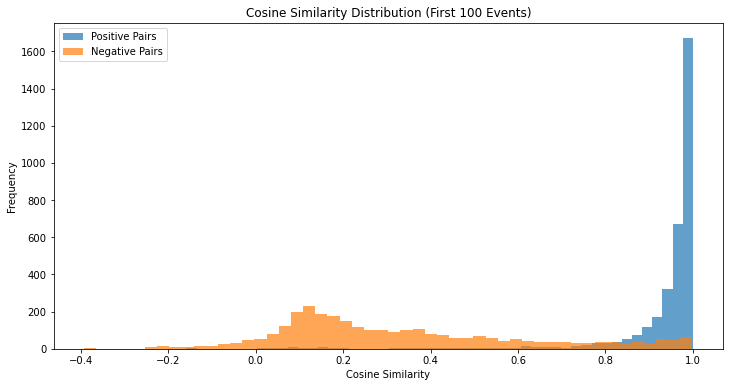

In [103]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr
from tqdm import tqdm
import torch
import torch.nn.functional as F

# Function to compute cosine similarities using sklearn's cosine_similarity.
def compute_cosine_similarities(embeddings, edge_indices, skip_self=True):
    """
    Given embeddings (NumPy array of shape [N, D]) and edge_indices (iterable of edges, each edge being a list or array),
    compute the cosine similarity for each edge using sklearn.metrics.pairwise.cosine_similarity.
    If skip_self is True, edges where source == target are skipped.
    Returns a NumPy array of similarities.
    """
    sims = []
    for edge in edge_indices:
        # Convert edge to a list if it's a tensor.
        edge = edge.tolist() if isinstance(edge, torch.Tensor) else edge
        src, tgt = edge
        if skip_self and src == tgt:
            continue
        # Compute cosine similarity for the two embeddings.
        sim = cosine_similarity(embeddings[[src, tgt], :])[0, 1]
        sims.append(sim)
    return np.array(sims)

num_events = 200  # Process the first 100 events

all_pos_sims = []
all_neg_sims = []

for i in tqdm(range(num_events), desc="Processing events"):
    # Convert predictions for event i to a tensor and normalize them.
    pred_tensor = torch.tensor(all_predictions[i], dtype=torch.float32)
    pred_norm = F.normalize(pred_tensor, p=2, dim=1)
    # Convert the normalized embeddings to a NumPy array.
    embeddings = pred_norm.cpu().numpy()
    
    # Get positive and negative edge indices for the event.
    pos_edge_indices = data_test[i].x_pe
    neg_edge_indices = data_test[i].x_ne
    # If edge indices are tensors, convert them to NumPy arrays.
    if torch.is_tensor(pos_edge_indices):
        pos_edge_indices = pos_edge_indices.cpu().numpy()
    if torch.is_tensor(neg_edge_indices):
        neg_edge_indices = neg_edge_indices.cpu().numpy()
    
    # Compute cosine similarities for positive and negative edges.
    pos_sims = compute_cosine_similarities(embeddings, pos_edge_indices, skip_self=True)
    neg_sims = compute_cosine_similarities(embeddings, neg_edge_indices, skip_self=True)
    
    all_pos_sims.extend(pos_sims.tolist())
    all_neg_sims.extend(neg_sims.tolist())

all_pos_sims = np.array(all_pos_sims)
all_neg_sims = np.array(all_neg_sims)

mean_pos_sim = np.mean(all_pos_sims)
mean_neg_sim = np.mean(all_neg_sims)

print(f"Mean Positive Edge Cosine Similarity: {mean_pos_sim:.4f}")
print(f"Mean Negative Edge Cosine Similarity: {mean_neg_sim:.4f}")

# Plot histograms for positive and negative cosine similarities.
plt.figure(figsize=(12, 6))
plt.hist(all_pos_sims, bins=50, alpha=0.7, label="Positive Pairs")
plt.hist(all_neg_sims, bins=50, alpha=0.7, label="Negative Pairs")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.title("Cosine Similarity Distribution (First 100 Events)")
plt.legend()
plt.show()


In [12]:
def calculate_sim_to_reco_score(CaloParticle, energies_indices, ReconstructedTrackster):
    """
    Calculate the sim-to-reco score for a given CaloParticle and ReconstructedTrackster.
    
    Parameters:
    - CaloParticle: array of Layer Clusters in the CaloParticle.
    - Multiplicity: array of Multiplicity for layer clusters in CP
    - energies_indices: array of energies associated with all LC (indexed by LC).
    - ReconstructedTrackster: array of LC in the reconstructed Trackster.
    
    Returns:
    - sim_to_reco_score: the calculated sim-to-reco score.
    """
    numerator = 0.0
    denominator = 0.0

    energy_caloparticle_lc = energies_indices[CaloParticle]
    total_energy_caloparticle = sum(energy_caloparticle_lc)
    if total_energy_caloparticle == 0:
        return 1.0  # No energy in the CaloParticle implies perfect mismatch

    # Calculate total energy of the ReconstructedTrackster
    total_energy_trackster = sum(energies_indices[det_id] for det_id in ReconstructedTrackster)
    i = 0
    # Iterate over all DetIds in the CaloParticle
    for det_id in CaloParticle:
        energy_k = energies_indices[det_id]  # Energy for the current DetId in CaloParticle
        # Fraction of energy in the Trackster (fr_k^TST)
        fr_tst_k = 1 if det_id in ReconstructedTrackster else 0.0
        # Fraction of energy in the CaloParticle (fr_k^SC)
        fr_sc_k = 1 

        # Update numerator using the min function
        numerator += min(
            (fr_tst_k - fr_sc_k) ** 2,  # First term in the min function
            fr_sc_k ** 2                # Second term in the min function
        ) * (energy_k ** 2)

        # Update denominator
        denominator += (fr_sc_k ** 2) * (energy_k ** 2)
        i+=1

    # Calculate score
    sim_to_reco_score = numerator / denominator if denominator != 0 else 1.0
    return sim_to_reco_score

def calculate_reco_to_sim_score(ReconstructedTrackster, energies_indices, CaloParticle):
    """
    Calculate the reco-to-sim score for a given ReconstructedTrackster and CaloParticle.

    Parameters:
    - ReconstructedTrackster: array of DetIds in the ReconstructedTrackster.
    - energies_indices: array of energies associated with all DetIds (indexed by DetId).
    - CaloParticle: array of DetIds in the CaloParticle.

    Returns:
    - reco_to_sim_score: the calculated reco-to-sim score.
    """
    numerator = 0.0
    denominator = 0.0

    # Calculate total energy of the ReconstructedTrackster
    total_energy_trackster = sum(energies_indices[det_id] for det_id in ReconstructedTrackster)
    if total_energy_trackster == 0:
        return 1.0  # No energy in the Trackster implies perfect mismatch

    energy_caloparticle_lc = energies_indices[CaloParticle] 
    total_energy_caloparticle = sum(energy_caloparticle_lc)
    # Iterate over all DetIds in the ReconstructedTrackster
    for det_id in ReconstructedTrackster:
        energy_k = energies_indices[det_id]  # Energy for the current DetId in the Trackster
        
        # Fraction of energy in the Trackster (fr_k^TST)
        fr_tst_k = 1

        #fr_sc_k = 1 if det_id in CaloParticle else 0.0
        if det_id in CaloParticle:
            fr_sc_k = 1
        else:
            fr_sc_k = 0
            
        # Update numerator using the min function
        numerator += min(
            (fr_tst_k - fr_sc_k) ** 2,  # First term in the min function
            fr_tst_k ** 2               # Second term in the min function
        ) * (energy_k ** 2)

        # Update denominator
        denominator += (fr_tst_k ** 2) * (energy_k ** 2)

    # Calculate score
    reco_to_sim_score = numerator / denominator if denominator != 0 else 1.0
    return reco_to_sim_score



import numpy as np
import pandas as pd
from tqdm import tqdm  # For progress bar

def calculate_all_event_scores(GT_ind, energies, recon_ind, LC_x, LC_y, LC_z, LC_eta, num_events = 100):
    """
    Calculate sim-to-reco and reco-to-sim scores for all CaloParticle and ReconstructedTrackster combinations across all events.

    Parameters:
    - GT_ind: List of CaloParticle indices for all events.
    - energies: List of energy arrays for all events.
    - recon_ind: List of ReconstructedTrackster indices for all events.
    - LC_x, LC_y, LC_z, LC_eta: Lists of x, y, z positions and eta values for all DetIds across events.

    Returns:
    - DataFrame containing scores and additional features for each CaloParticle-Trackster combination across all events.
    """
    # Initialize an empty list to store results
    all_results = []

    # Loop over all events with a progress bar
    for event_index in tqdm(range(num_events)):
        caloparticles = GT_ind[event_index]  # Indices for all CaloParticles in the event
        tracksters = recon_ind[event_index]  # Indices for all ReconstructedTracksters in the event
        event_energies = energies[event_index]  # Energies for this event


        # Extract layer cluster positions and eta for this event
        event_x = np.array(LC_x[event_index])
        event_y = np.array(LC_y[event_index])
        event_z = np.array(LC_z[event_index])
        event_eta = np.array(LC_eta[event_index])

        # Compute barycenter for each CaloParticle
        cp_barycenters = []
        cp_avg_etas = []
        for caloparticle in caloparticles:
            # Compute barycenter (x, y, z)
            
            barycenter_x = np.mean([event_x[det_id] for det_id in caloparticle])
            barycenter_y = np.mean([event_y[det_id] for det_id in caloparticle])
            barycenter_z = np.mean([event_z[det_id] for det_id in caloparticle])
            cp_barycenters.append(np.array([barycenter_x, barycenter_y, barycenter_z]))
            
            # Compute average eta
            avg_eta = np.mean([event_eta[det_id] for det_id in caloparticle])
            cp_avg_etas.append(avg_eta)

        # Compute separation between two CaloParticles if at least two exist
        if len(cp_barycenters) >= 2:
            cp_separation = np.linalg.norm(cp_barycenters[0] - cp_barycenters[1])
        else:
            cp_separation = 0.0
            
        trackster_det_id_sets = [set(trackster) for trackster in tracksters]

        # Loop over all CaloParticles
        for calo_idx, caloparticle in enumerate(caloparticles):

            calo_det_ids = set(calo_id for calo_id in caloparticle)
            # Loop over all Tracksters
            for trackster_idx, trackster in enumerate(tracksters):
                # Calculate sim-to-reco score
                trackster_det_ids = trackster_det_id_sets[trackster_idx]
                shared_det_ids = calo_det_ids.intersection(trackster_det_ids)
                
                # Calculate shared_energy by summing energies of shared det_ids
                shared_energy = np.sum(event_energies[list(shared_det_ids)]) if shared_det_ids else 0.0
                
                
                sim_to_reco_score = calculate_sim_to_reco_score(caloparticle, event_energies, trackster)
                # Calculate reco-to-sim score
                reco_to_sim_score = calculate_reco_to_sim_score(trackster, event_energies, caloparticle)

                # Calculate total energy for CaloParticle and Trackster
                cp_energy_lc2 = event_energies[caloparticle] 
                cp_energy = np.sum(cp_energy_lc2)
                
                trackster_energy = np.sum([event_energies[det_id] for det_id in trackster])

                # Calculate energy difference ratio
                energy_diff_ratio = (trackster_energy / cp_energy if cp_energy != 0 else None)

                # Append results
                all_results.append({
                    "event_index": event_index,
                    "cp_id": calo_idx,
                    "trackster_id": trackster_idx,
                    "sim_to_reco_score": sim_to_reco_score,
                    "reco_to_sim_score": reco_to_sim_score,
                    "cp_energy": cp_energy,
                    "trackster_energy": trackster_energy,
                    "cp_avg_eta": cp_avg_etas[calo_idx],
                    "cp_separation": cp_separation,
                    "energy_ratio": energy_diff_ratio,
                    "shared_energy": shared_energy  # New column
                })

    # Convert results to a DataFrame
    df = pd.DataFrame(all_results)
    return df




In [13]:
#4: Calculate Scores and create DF for our model and TICL

#4.1: Turn the cluster labels into our reconstructed tracksters

recon_ind = []

for event_idx, labels in enumerate(all_cluster_labels):

    event_clusters = {} 
    
    for cluster_idx, cluster_label in enumerate(labels):
        if cluster_label not in event_clusters:
            event_clusters[cluster_label] = []
        event_clusters[cluster_label].extend(Track_ind[event_idx][cluster_idx])
    
    recon_ind.append([event_clusters[label] for label in sorted(event_clusters.keys())])

#4.2 Make DF from our model and CERN


In [14]:
df_CL = calculate_all_event_scores(GT_ind, energies, recon_ind, LC_x, LC_y, LC_z, LC_eta, num_events = 2000)
df_TICL = calculate_all_event_scores(GT_ind, energies, MT_ind_filt, LC_x, LC_y, LC_z, LC_eta, num_events = 2000)

100%|███████████████████████████████████████| 2000/2000 [09:16<00:00,  3.59it/s]


In [9]:
df_CL = pd.read_csv('df_CL_mix_015.csv')
df_TICL = pd.read_csv('df_CERN_mix.csv')

In [10]:
df_CL['pgid'] = df_CL.apply(lambda row: pgid[int(row['event_index'])][int(row['cp_id'])], axis=1)
df_TICL['pgid'] = df_TICL.apply(lambda row: pgid[int(row['event_index'])][int(row['cp_id'])], axis=1)


In [20]:
def calculate_metrics(df, model_name):
    # Filter to only include rows with pgid == 211.
    #df = df[df['pgid'] == 211].copy()
    
    # ----- Efficiency Calculation -----
    # Step 1: Filter out rows where 'cp_id' is NaN
    cp_valid = df.dropna(subset=['cp_id']).copy()

    # Step 2: Group by 'event_index' and 'cp_id' to process each CaloParticle individually
    cp_grouped = cp_valid.groupby(['event_index', 'cp_id'])

    # Step 3: For each CaloParticle, check if any 'shared_energy' >= 50% of 'cp_energy'
    def is_cp_associated(group):
        cp_energy = group['cp_energy'].iloc[0]  # Assuming 'cp_energy' is consistent within the group
        threshold = 0.5 * cp_energy
        return (group['shared_energy'] >= threshold).any()

    # Apply the association function to each group
    cp_associated = cp_grouped.apply(is_cp_associated)

    # Step 4: Calculate the number of associated CaloParticles and total CaloParticles
    num_associated_cp = cp_associated.sum()
    total_cp = cp_associated.count()
    efficiency = num_associated_cp / total_cp if total_cp > 0 else 0

    # ----- Purity Calculation -----
    tst_valid = df.dropna(subset=['trackster_id']).copy()
    tst_grouped = tst_valid.groupby(['event_index', 'trackster_id'])

    # A Trackster is "associated" if reco_to_sim_score < 0.2 for at least one CP
    tst_associated = tst_grouped['reco_to_sim_score'].min() < 0.2
    num_associated_tst = tst_associated.sum()
    total_tst = tst_associated.count()
    purity = num_associated_tst / total_tst if total_tst > 0 else 0

    # ----- Containment Calculation -----
    #  (similar approach, but now we look at Sim-to-Reco < 0.2)
    cp_valid_cont = df.dropna(subset=['cp_id']).copy()
    cp_grouped_cont = cp_valid_cont.groupby(['event_index', 'cp_id'])
    cp_associated_cont = cp_grouped_cont['sim_to_reco_score'].min() < 0.2
    num_associated_cp_cont = cp_associated_cont.sum()
    total_cp_cont = cp_associated_cont.count()
    containment = num_associated_cp_cont / total_cp_cont if total_cp_cont > 0 else 0

    # ----- Duplicate Rate -----
    # Number of simulated objects (CaloParticles) that have been associated (Sim-to-Reco < 0.2)
    # to multiple Tracksters, divided by the total number of simulated objects.
    cp_grouped_dup = cp_valid.groupby(['event_index', 'cp_id'])

    def get_associated_tracksters_cp(group):
        # Return the unique Trackster IDs for which sim_to_reco_score < 0.2
        return group[group['sim_to_reco_score'] < 0.2]['trackster_id'].unique()

    cp_associated_tracksters = cp_grouped_dup.apply(get_associated_tracksters_cp)

    # A CP is "duplicated" if it's associated with more than one Trackster
    duplicate_count = (cp_associated_tracksters.apply(lambda x: len(x) > 1)).sum()
    total_cp_dup = len(cp_associated_tracksters)
    duplicate_rate = duplicate_count / total_cp_dup if total_cp_dup > 0 else 0

    # ----- Merge Rate -----
    # Number of reconstructed objects (Tracksters) that have been associated (Reco-to-Sim < 0.2)
    # to multiple simulated objects, divided by the total number of reconstructed objects.
    tst_grouped_merge = tst_valid.groupby(['event_index', 'trackster_id'])

    def get_associated_cps_tst(group):
        # Return the unique CP IDs for which reco_to_sim_score < 0.2
        return group[group['reco_to_sim_score'] < 0.2]['cp_id'].unique()

    tst_associated_cps = tst_grouped_merge.apply(get_associated_cps_tst)

    # A Trackster is "merged" if it's associated with more than one CP
    merge_count = (tst_associated_cps.apply(lambda x: len(x) > 1)).sum()
    total_tst_merge = len(tst_associated_cps)
    merge_rate = merge_count / total_tst_merge if total_tst_merge > 0 else 0

    # Print results for the model
    print(f"\nModel: {model_name}")
    print(f"Efficiency:  {efficiency:.4f} ({num_associated_cp} / {total_cp})")
    print(f"Containment: {containment:.4f} ({num_associated_cp_cont} / {total_cp_cont})")
    print(f"Purity:      {purity:.4f} ({num_associated_tst} / {total_tst})")
    print(f"Duplicate Rate: {duplicate_rate:.4f} ({duplicate_count} CPs out of {total_cp_dup} total)")
    print(f"Merge Rate:     {merge_rate:.4f} ({merge_count} Tracksters out of {total_tst_merge} total)")
    print(f"Num tracksters ratio: {total_tst / total_cp if total_cp > 0 else 0:.4f}")

    return {
        'efficiency': efficiency,
        'purity': purity,
        'containment': containment,
        'duplicate_rate': duplicate_rate,
        'merge_rate': merge_rate
    }

# Example usage
our_model_metrics = calculate_metrics(df_CL, "Our Model")
cern_model_metrics = calculate_metrics(df_TICL, "CERN Model")



Model: Our Model
Efficiency:  0.7695 (1135 / 1475)
Containment: 0.6217 (917 / 1475)
Purity:      0.9750 (1598 / 1639)
Duplicate Rate: 0.0000 (0 CPs out of 1475 total)
Merge Rate:     0.0000 (0 Tracksters out of 1639 total)
Num tracksters ratio: 1.1112

Model: CERN Model
Efficiency:  0.7708 (1137 / 1475)
Containment: 0.6339 (935 / 1475)
Purity:      0.9784 (2623 / 2681)
Duplicate Rate: 0.0000 (0 CPs out of 1475 total)
Merge Rate:     0.0000 (0 Tracksters out of 2681 total)
Num tracksters ratio: 1.8176


/tmp/ipykernel_2022152/3075020710.py:120: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "x" (-> marker='x'). The keyword argument will take precedence.
  ax1.errorbar(bin_centers, manual_efficiency, yerr=manual_eff_error,


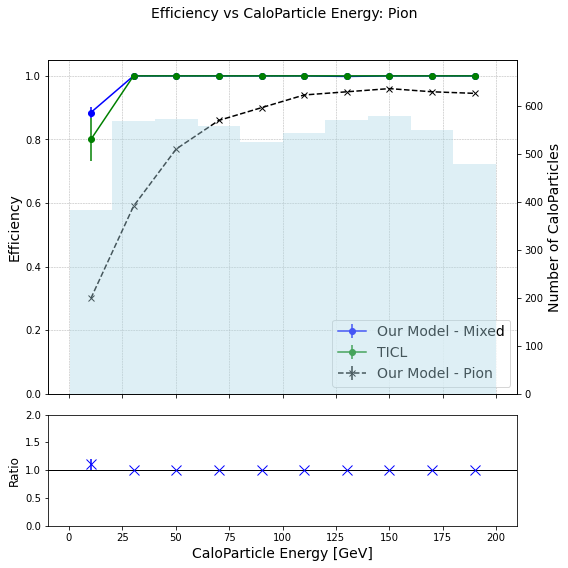

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------
# Load Your DataFrames
# ---------------------------
# Replace the following with your actual data loading mechanism.
# For example:
# df_CL = pd.read_csv('df_CL.csv')
# df_TICL = pd.read_csv('df_TICL.csv')
# (If you have df_CL_pion, you can ignore its processing for now.)

# ---------------------------
# Preprocessing for df_CL and df_TICL
# ---------------------------
for df in [df_CL, df_TICL]:
    df['cp_id'] = pd.to_numeric(df['cp_id'], errors='coerce')
    df['shared_energy'] = pd.to_numeric(df['shared_energy'], errors='coerce')
    df['cp_energy'] = pd.to_numeric(df['cp_energy'], errors='coerce')

# Filter to only include rows with a pgid of 211 or -211.
df_CL2 = df_CL[df_CL['pgid'].isin([11, -11])]
df_TICL2 = df_TICL[df_TICL['pgid'].isin([11, -11])]

# ---------------------------
# (Optional) Remove df_CL_pion processing if not needed
# ---------------------------
# df_CL_pion['cp_id'] = pd.to_numeric(df_CL_pion['cp_id'], errors='coerce')
# df_CL_pion['shared_energy'] = pd.to_numeric(df_CL_pion['shared_energy'], errors='coerce')
# df_CL_pion['cp_energy'] = pd.to_numeric(df_CL_pion['cp_energy'], errors='coerce')
# df_CL_pion2 = df_CL_pion[df_CL_pion['pgid'].isin([211, -211])]

# ---------------------------
# Define a Function to Prepare CaloParticle Data
# ---------------------------
def prepare_cp_data(df):
    """
    Group the DataFrame by ['event_index', 'cp_id'] so that each caloparticle is counted once.
    For each group:
      - Take the first cp_energy.
      - Take the maximum shared_energy to check if any shared_energy >= 50% of cp_energy.
      - Mark the caloparticle as 'reconstructed' if any shared_energy >= 50% of cp_energy.
    """
    grouped = df.groupby(['event_index', 'cp_id']).agg({
        'cp_energy': 'first',
        'shared_energy': 'max'
    }).reset_index()
    grouped['reco'] = (grouped['shared_energy'] >= 0.5 * grouped['cp_energy']).astype(int)
    return grouped

# Prepare the caloparticle data for each DataFrame.
df_CL_cp = prepare_cp_data(df_CL2)
df_TICL_cp = prepare_cp_data(df_TICL2)
# (No processing for df_CL_pion since we are adding manual data.)

# ---------------------------
# Define Energy Bins
# ---------------------------
# Use the range of cp_energy from df_CL_cp to define bins.
min_energy = df_CL_cp['cp_energy'].min()
max_energy = 200
n_bins = 10
energy_bins = np.linspace(min_energy, max_energy, n_bins + 1)

# Assign each caloparticle to an energy bin.
df_CL_cp['energy_bin'] = pd.cut(df_CL_cp['cp_energy'], bins=energy_bins, labels=False, include_lowest=True)
df_TICL_cp['energy_bin'] = pd.cut(df_TICL_cp['cp_energy'], bins=energy_bins, labels=False, include_lowest=True)

# ---------------------------
# Aggregate Efficiency Data
# ---------------------------
def aggregate_efficiency(df):
    """
    For each energy bin, calculate:
      - The total number of caloparticles in the bin.
      - The number of reconstructed caloparticles.
      - Efficiency = (reconstructed caloparticles) / (total number).
      - An error estimate based on binomial statistics.
    """
    agg = df.groupby('energy_bin').agg(
        total_cp=('cp_energy', 'count'),
        reco_cp=('reco', 'sum')
    ).reset_index()
    agg['efficiency'] = agg['reco_cp'] / agg['total_cp']
    agg['eff_error'] = np.sqrt(agg['efficiency'] * (1 - agg['efficiency']) / agg['total_cp'])
    return agg

agg_CL = aggregate_efficiency(df_CL_cp)
agg_TICL = aggregate_efficiency(df_TICL_cp)
# (No aggregation for df_CL_pion is performed.)

# ---------------------------
# Plot Efficiency vs Energy with Histogram and Ratio Plot
# ---------------------------
# Compute bin centers for plotting: average of adjacent bin edges.
bin_centers = (energy_bins[:-1] + energy_bins[1:]) / 2
bar_width = energy_bins[1] - energy_bins[0]

# Calculate efficiency ratio (Our Model / TICL) and its error.
eff_ratio = agg_CL['efficiency'] / agg_TICL['efficiency']
eff_ratio_error = eff_ratio * np.sqrt(
    (agg_CL['eff_error'] / agg_CL['efficiency'])**2 + 
    (agg_TICL['eff_error'] / agg_TICL['efficiency'])**2
)

# Create a figure with two subplots: one for efficiency curves and histogram, and one for the ratio.
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

# ----- Efficiency Plot -----
ax1.errorbar(bin_centers, agg_CL['efficiency'], yerr=agg_CL['eff_error'],
             marker='o', linestyle='-', color='blue', label='Our Model - Mixed')
ax1.errorbar(bin_centers, agg_TICL['efficiency'], yerr=agg_TICL['eff_error'],
             marker='o', linestyle='-', color='green', label='TICL')

# Add a new manual curve.
# Replace these arrays with your manual data for each energy bin.
manual_efficiency = np.array([0.3, 0.59, 0.77, 0.86, 0.9, 0.94, 0.95, 0.96, 0.95, 0.945])
manual_eff_error = np.array([0.0] * len(manual_efficiency))
ax1.errorbar(bin_centers, manual_efficiency, yerr=manual_eff_error,
             marker='x', fmt='x', linestyle='--', color='black', label='Our Model - Pion')

ax1.set_ylabel('Efficiency', fontsize=14)
ax1.set_ylim(0, 1.05)
ax1.legend(loc='lower right', fontsize=14)
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# Add a secondary y-axis to show the number of CaloParticles as a histogram.
ax1_hist = ax1.twinx()
ax1_hist.bar(bin_centers, agg_CL['total_cp'], width=bar_width, color='lightblue', alpha=0.4)
ax1_hist.set_ylabel('Number of CaloParticles', fontsize=14)
ax1_hist.set_ylim(0, agg_CL['total_cp'].max() * 1.2)

# ----- Ratio Plot -----
ax2.errorbar(bin_centers, eff_ratio, yerr=eff_ratio_error, fmt='x', color='blue', markersize=10)
ax2.axhline(1.0, color='black', linestyle='-', linewidth=1)
ax2.set_xlabel('CaloParticle Energy [GeV]', fontsize=14)
ax2.set_ylabel('Ratio', fontsize=12)
ax2.set_ylim(0.0, 2.00)

# Update Title to Reflect the Efficiency Study
plt.suptitle(r'Efficiency vs CaloParticle Energy: Pion', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


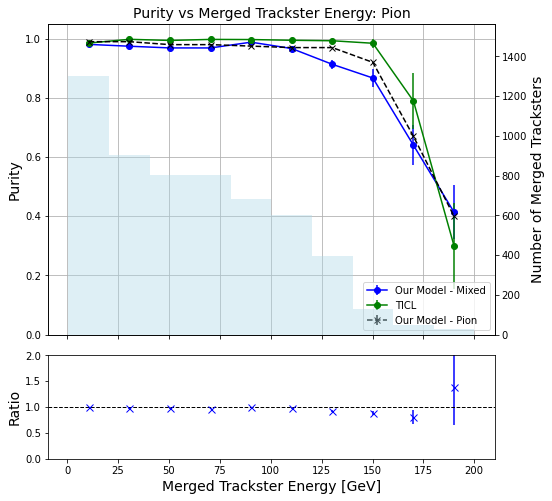

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert relevant columns to numeric.
for df in [df_CL, df_TICL]:
    df['trackster_id'] = pd.to_numeric(df['trackster_id'], errors='coerce')
    df['reco_to_sim_score'] = pd.to_numeric(df['reco_to_sim_score'], errors='coerce')
    df['trackster_energy'] = pd.to_numeric(df['trackster_energy'], errors='coerce')

# -----------------------------
# Prepare Trackster-Level Data for Purity
# -----------------------------
def prepare_trackster_data(df):
    """
    Group the DataFrame by ['event_index', 'trackster_id'] so that each trackster is counted once.
    For each group:
      - Take the first trackster_energy,
      - Take the minimum reco_to_sim_score,
      - Mark the trackster as 'associated' if the minimum reco_to_sim_score is < 0.2.
    """
    grouped = df.groupby(['event_index', 'trackster_id']).agg({
        'trackster_energy': 'first',
        'reco_to_sim_score': 'min'
    }).reset_index()
    
    grouped['assoc'] = (grouped['reco_to_sim_score'] < 0.2).astype(int)
    return grouped

# Prepare the trackster-level data for both DataFrames.
df_CL_ts = prepare_trackster_data(df_CL)
df_TICL_ts = prepare_trackster_data(df_TICL)

# -----------------------------
# Bin Tracksters by Energy
# -----------------------------
# Define energy bins based on the range of trackster_energy from df_CL.
min_energy_ts = df_CL_ts['trackster_energy'].min()
max_energy_ts = 200
n_bins_ts = 10  # Adjust the number of bins if desired.
energy_bins_ts = np.linspace(min_energy_ts, max_energy_ts, n_bins_ts + 1)

# Assign each trackster to an energy bin.
df_CL_ts['energy_bin'] = pd.cut(df_CL_ts['trackster_energy'],
                                bins=energy_bins_ts, labels=False, include_lowest=True)
df_TICL_ts['energy_bin'] = pd.cut(df_TICL_ts['trackster_energy'],
                                  bins=energy_bins_ts, labels=False, include_lowest=True)

# -----------------------------
# Calculate Purity per Energy Bin
# -----------------------------
def aggregate_purity(df):
    """
    For each energy bin, calculate:
      - Total number of tracksters,
      - Number of associated tracksters (with reco_to_sim_score < 0.2),
      - Purity = (number of associated tracksters) / (total number).
    """
    agg = df.groupby('energy_bin').agg(
        total_ts=('trackster_energy', 'count'),
        assoc_ts=('assoc', 'sum')
    ).reset_index()
    agg['purity'] = agg['assoc_ts'] / agg['total_ts']
    agg['purity_error'] = np.sqrt(agg['purity'] * (1 - agg['purity']) / agg['total_ts'])
    return agg

agg_CL_ts = aggregate_purity(df_CL_ts)
agg_TICL_ts = aggregate_purity(df_TICL_ts)

# Reindex both aggregated DataFrames so that they have one row per energy bin (0 to n_bins_ts-1)
agg_CL_ts = agg_CL_ts.set_index('energy_bin').reindex(range(n_bins_ts), fill_value=np.nan).reset_index()
agg_TICL_ts = agg_TICL_ts.set_index('energy_bin').reindex(range(n_bins_ts), fill_value=np.nan).reset_index()

# -----------------------------
# Plot Purity vs Trackster Energy with Histogram Overlay
# -----------------------------
# Compute bin centers for plotting: average of adjacent bin edges.
bin_centers_ts = (energy_bins_ts[:-1] + energy_bins_ts[1:]) / 2
bar_width_ts = energy_bins_ts[1] - energy_bins_ts[0]

# Calculate the purity ratio (Our Model / TICL) and its error.
purity_ratio = agg_CL_ts['purity'] / agg_TICL_ts['purity']
purity_ratio_error = purity_ratio * np.sqrt(
    (agg_CL_ts['purity_error'] / agg_CL_ts['purity'])**2 +
    (agg_TICL_ts['purity_error'] / agg_TICL_ts['purity'])**2
)

# Create a figure with two subplots: one for purity curves (with histogram) and one for the ratio.
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8),
                                gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
plt.subplots_adjust(hspace=0.1)  # Minimal vertical spacing

# ----- Purity Plot (Primary y-axis) -----
ax1.errorbar(bin_centers_ts, agg_CL_ts['purity'], yerr=agg_CL_ts['purity_error'],
             marker='o', linestyle='-', color='blue', label='Our Model - Mixed')
ax1.errorbar(bin_centers_ts, agg_TICL_ts['purity'], yerr=agg_TICL_ts['purity_error'],
             marker='o', linestyle='-', color='green', label='TICL')

# ----- Third (Manual) Line -----
# Replace these arrays with your desired points and errors for each energy bin.
manual_purity = np.array([0.99, 0.99, 0.98, 0.98, 0.975, 0.97, 0.97, 0.92, 0.67, 0.4])
manual_purity_error = np.array([0.0] * len(manual_purity))
ax1.errorbar(bin_centers_ts, manual_purity, yerr=manual_purity_error,
             marker='x', linestyle='--', color='black', label='Our Model - Pion')

ax1.set_ylabel('Purity', fontsize=14)
ax1.set_ylim(0, 1.05)
ax1.legend(loc='lower right')
ax1.grid(True)

# Plot histogram (number of merged tracksters per energy bin) on a secondary y-axis.
ax1_hist = ax1.twinx()
ax1_hist.bar(bin_centers_ts, agg_CL_ts['total_ts'], width=bar_width_ts,
             color='lightblue', alpha=0.4)
ax1_hist.set_ylabel('Number of Merged Tracksters', fontsize=14)
ax1_hist.set_ylim(0, agg_CL_ts['total_ts'].max() * 1.2)

# ----- Ratio Plot -----
ax2.errorbar(bin_centers_ts, purity_ratio, yerr=purity_ratio_error,
             fmt='x', color='blue', markersize=7)
ax2.axhline(1.0, color='black', linestyle='--', linewidth=1)
ax2.set_xlabel('Merged Trackster Energy [GeV]', fontsize=14)
ax2.set_ylabel('Ratio', fontsize=14)
ax2.set_ylim(0, 2.0)

plt.title(r'Purity vs Merged Trackster Energy: Pion', fontsize=14)
plt.savefig("PionvsEn.pdf")
plt.show()


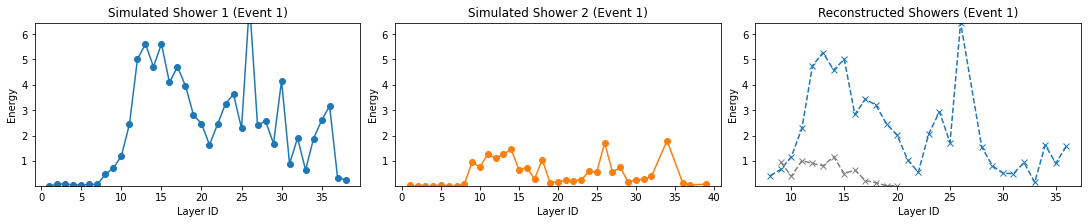

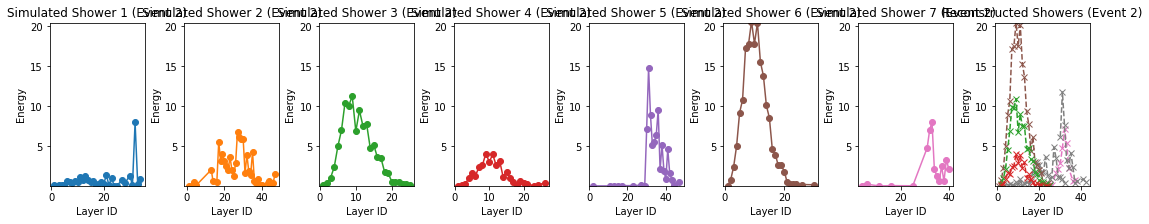

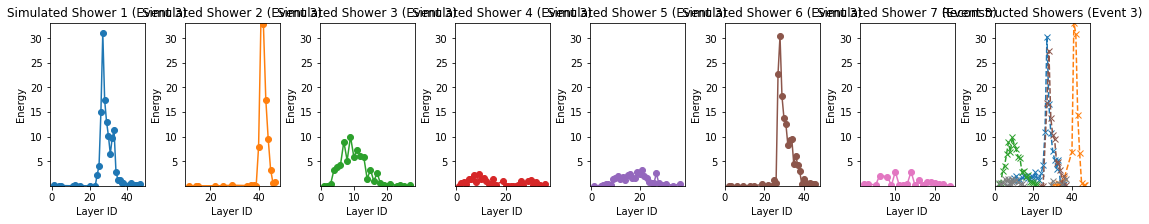

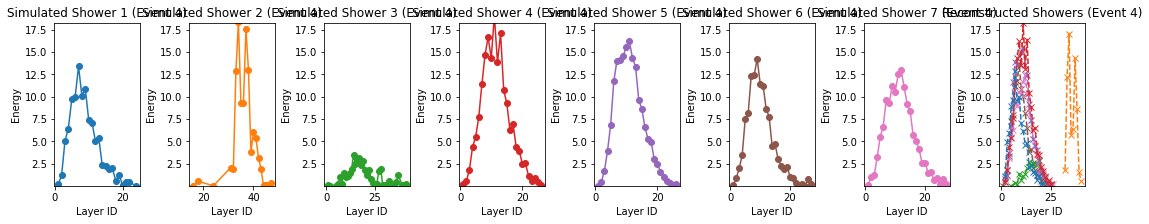

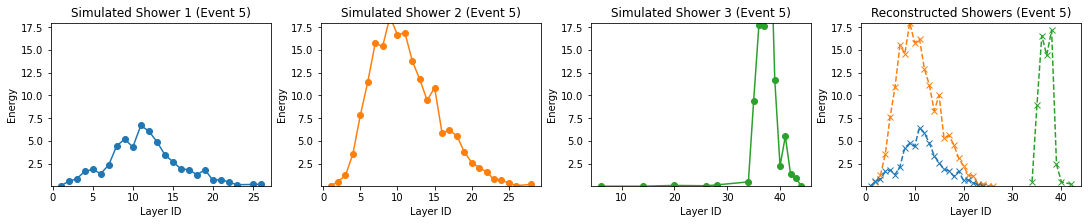

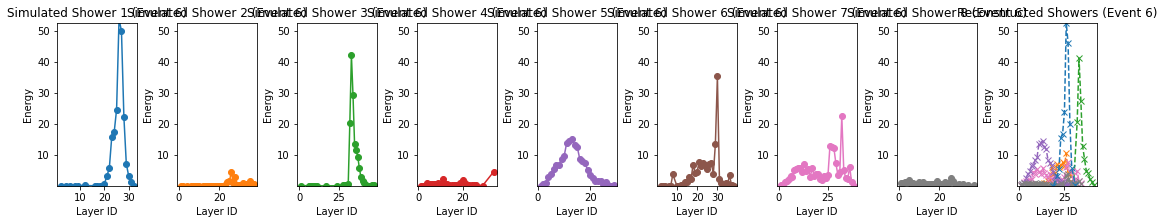

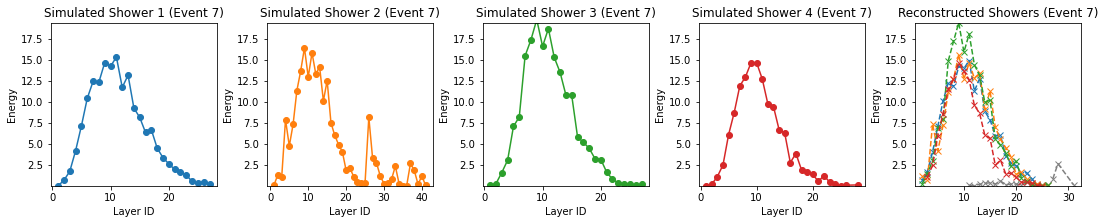

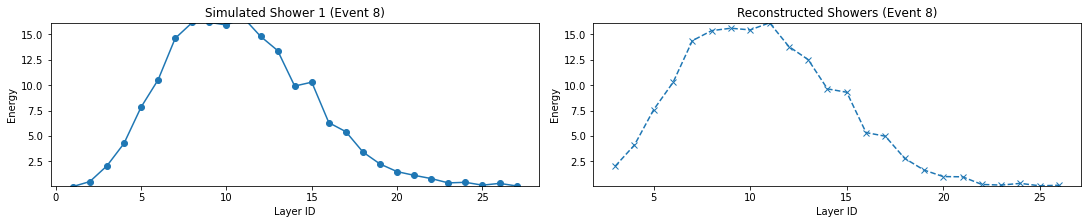

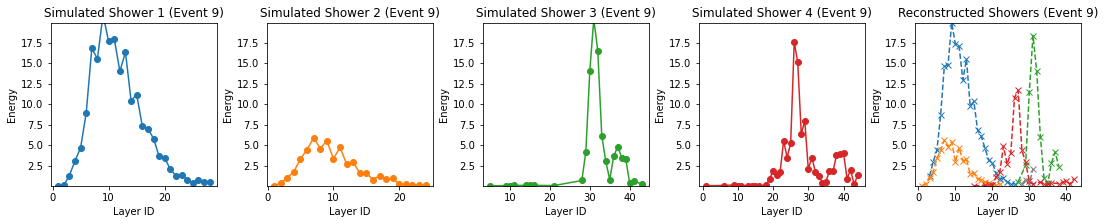

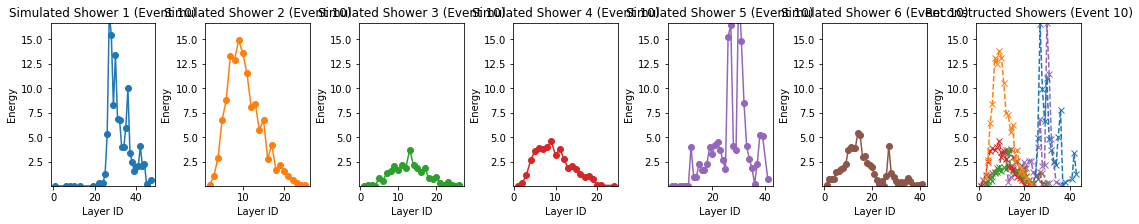

In [33]:
# Plotting longitudinal energy profiles of both simulated and reconstructed showers along with associated pairs.

import matplotlib.colors as mcolors

layer = data_file['clusters']['cluster_layer_id'].array()

def calculate_all_event_profile_data(GT_ind, energies, recon_ind, layer, multi, num_events=10):
    # Define unique colors for caloparticles
    colors = list(mcolors.TABLEAU_COLORS.values())

    # Loop over all events
    for event_index in range(num_events):
        # Get data for the current event
        caloparticles = GT_ind[event_index]  # Indices for all CaloParticles in the event
        tracksters = recon_ind[event_index]  # Indices for all ReconstructedTracksters in the event
        event_energies = energies[event_index]  # Energies for this event
        event_layer_id = layer[event_index]
        event_multi = multi[event_index]

        # Initialize lists for profiles and associations
        simulated_profiles = []
        reconstructed_profiles = []
        associations = {}  # To store caloparticle-trackster associations

        # Simulated particle shower
        for cp_idx, caloparticle in enumerate(caloparticles):
            cp_lc_layer_id = event_layer_id[caloparticle]
            cp_lc_energies = event_energies[caloparticle] / event_multi[cp_idx]
            df_cp = pd.DataFrame({'energy': cp_lc_energies, 'layer_id': cp_lc_layer_id})
            layer_energy_cp = df_cp.groupby('layer_id')['energy'].sum().reset_index()
            simulated_profiles.append(layer_energy_cp)

        # Reconstructed particle shower
        for trackster in tracksters:
            tst_lc_layer_id = event_layer_id[trackster]
            tst_lc_energies = event_energies[trackster]
            df_tst = pd.DataFrame({'energy': tst_lc_energies, 'layer_id': tst_lc_layer_id})
            layer_energy_tst = df_tst.groupby('layer_id')['energy'].sum().reset_index()
            reconstructed_profiles.append(layer_energy_tst)

        # Calculate sim_to_reco score and determine associations


        for calo_idx, caloparticle in enumerate(caloparticles):
            Calo_multi = event_multi[calo_idx]
            cp_energy = np.sum(event_energies[caloparticle] / Calo_multi)
            
            # Loop over all Tracksters
            max_shared_energy = 0.0
            best_tst_idx = None
            
            for trackster_idx, trackster in enumerate(tracksters):
                # Calculate sim-to-reco score
                
                
                shared_det_ids = set(calo_det_id for calo_det_id in caloparticle).intersection(set(trackster))
                if not shared_det_ids:
                    continue  # No shared det_ids

                # Calculate shared_energy
                shared_energy = np.sum(event_energies[list(shared_det_ids)])

                # Check if shared_energy meets the threshold
                if shared_energy >= 0.5 * cp_energy and shared_energy > max_shared_energy:
                    max_shared_energy = shared_energy
                    best_tst_idx = trackster_idx

            if best_tst_idx is not None:
                associations[calo_idx] = best_tst_idx
                    
        
        
        # Determine energy range from reconstructed showers for consistent y-axis
        min_energy = min(profile['energy'].min() for profile in reconstructed_profiles)
        max_energy = max(profile['energy'].max() for profile in reconstructed_profiles)
    
    
        # Plot simulated profiles
        fig, axes = plt.subplots(1, len(simulated_profiles) + 1, figsize=(15, 3), constrained_layout=True)

        for idx, profile in enumerate(simulated_profiles):
            ax = axes[idx]
            ax.plot(profile['layer_id'], profile['energy'], marker='o', linestyle='-', color=colors[idx % len(colors)])
            ax.set_ylim(min_energy, max_energy)
            ax.set_title(f'Simulated Shower {idx + 1} (Event {event_index + 1})')
            ax.set_xlabel('Layer ID')
            ax.set_ylabel('Energy')

        # Plot all reconstructed profiles in a single plot
        ax = axes[-1]
        for idx, profile in enumerate(reconstructed_profiles):
            # Determine color based on association
            associated_cp = [cp_idx for cp_idx, tst_idx in associations.items() if tst_idx == idx]
            color = colors[associated_cp[0] % len(colors)] if associated_cp else 'gray'
            ax.plot(profile['layer_id'], profile['energy'], marker='x', linestyle='--', color=color)
        ax.set_ylim(min_energy, max_energy)
        ax.set_title(f'Reconstructed Showers (Event {event_index + 1})')
        ax.set_xlabel('Layer ID')
        ax.set_ylabel('Energy')

        # Show the plots
        plt.show()

events_ours = calculate_all_event_profile_data(GT_ind, energies, recon_ind, layer, GT_mult)


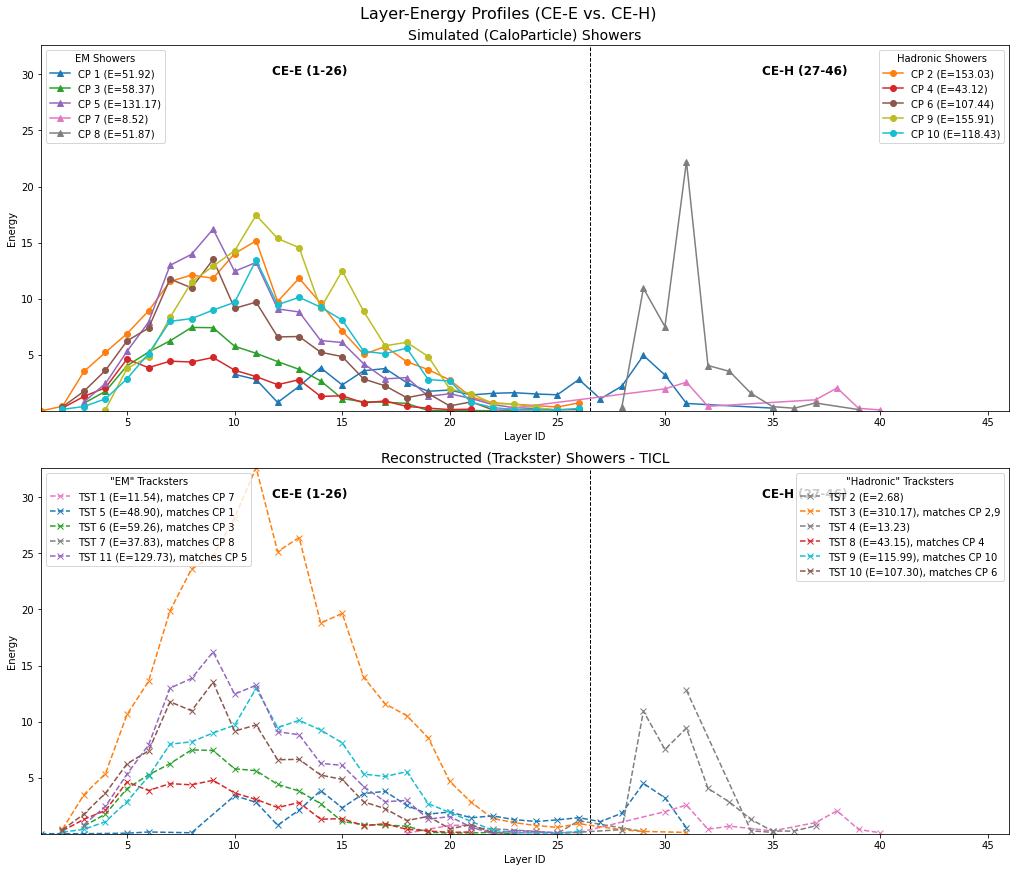

/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


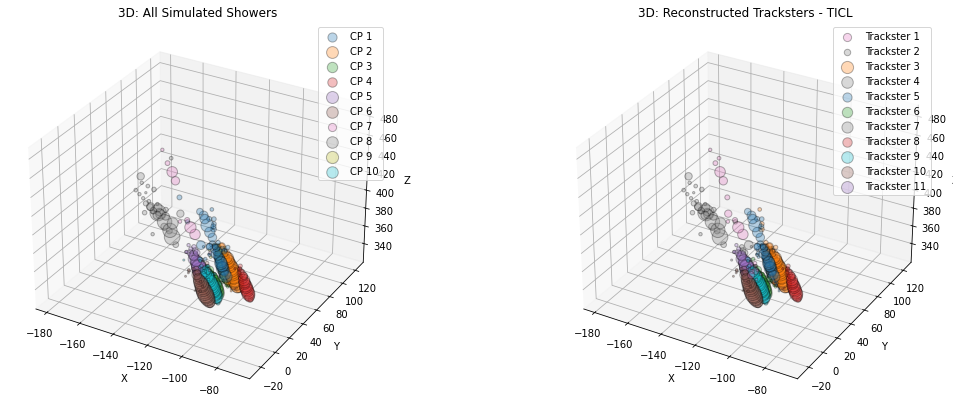

In [74]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D

# Ensure "plots" directory exists
os.makedirs("plots", exist_ok=True)

def calculate_event_profile_data(GT_ind, energies, recon_ind, layer, multi, event_index=0):
    """
    Creates two figures:

    1) A single 2D figure with two subplots, stacked vertically:
       - Top subplot: All Simulated (CaloParticle) showers vs. layer (1..46)
       - Bottom subplot: All Reconstructed (Trackster) showers vs. layer (1..46)
         A dashed vertical line at x=26.5 indicates the boundary between CE-E (1..26)
         and CE-H (27..46).
         We highlight CaloParticles #1, #3, #5, #7, #8 (1-based) and any tracksters
         associated with them (full opacity, placed in a "left" legend). All others
         appear at reduced opacity (in a "right" legend).

    2) A 3D figure with side-by-side subplots:
       - Left: All simulated showers in 3D
       - Right: All reconstructed showers in 3D
    """

    # ---------------------- Setup / Data Extraction ----------------------
    # Tableau colors for distinct color choices
    colors = list(mcolors.TABLEAU_COLORS.values())

    # Extract the data for the chosen event
    caloparticles = GT_ind[event_index]  # Indices for CaloParticles in the event
    tracksters   = recon_ind[event_index]  # Indices for ReconstructedTracksters in the event
    event_energies = energies[event_index]  # Energies for this event
    event_layer_id = layer[event_index]
    event_multi    = multi[event_index]
    event_LC_x     = LC_x[event_index]
    event_LC_y     = LC_y[event_index]
    event_LC_z     = LC_z[event_index]

    # To store the layer profiles
    simulated_profiles = []     # list of DataFrames, one per CP
    reconstructed_profiles = [] # list of DataFrames, one per Trackster

    # For 3D visualization
    cp_lc_pos_all = []
    cp_lc_energies_all = []
    tst_lc_pos_all = []
    tst_lc_energies_all = []

    # Summed energies
    total_cp_energies = []
    total_tst_energies = []

    # For mapping CaloParticles to Tracksters (associations)
    associations = {}

    # ---------------------- Build Simulated (CaloParticle) Profiles ----------------------
    for cp_idx, caloparticle in enumerate(caloparticles):
        cp_lc_layer_id = event_layer_id[caloparticle]
        cp_lc_energies = event_energies[caloparticle] / event_multi[cp_idx]

        df_cp = pd.DataFrame({
            'layer_id': cp_lc_layer_id,
            'energy': cp_lc_energies
        })
        layer_energy_cp = df_cp.groupby('layer_id')['energy'].sum().reset_index()
        simulated_profiles.append(layer_energy_cp)

        cp_lc_pos_all.append([
            event_LC_x[caloparticle],
            event_LC_y[caloparticle],
            event_LC_z[caloparticle]
        ])
        cp_lc_energies_all.append(cp_lc_energies)
        total_cp_energies.append(layer_energy_cp['energy'].sum())

    # Assign each simulated shower a color
    cp_color_map = {
        cp_idx: colors[cp_idx % len(colors)]
        for cp_idx in range(len(simulated_profiles))
    }

    # ---------------------- Build Reconstructed (Trackster) Profiles ----------------------
    for trackster in tracksters:
        tst_lc_layer_id = event_layer_id[trackster]
        tst_lc_energies = event_energies[trackster]

        df_tst = pd.DataFrame({
            'layer_id': tst_lc_layer_id,
            'energy': tst_lc_energies
        })
        layer_energy_tst = df_tst.groupby('layer_id')['energy'].sum().reset_index()
        reconstructed_profiles.append(layer_energy_tst)

        tst_lc_pos_all.append([
            event_LC_x[trackster],
            event_LC_y[trackster],
            event_LC_z[trackster]
        ])
        tst_lc_energies_all.append(tst_lc_energies)
        total_tst_energies.append(layer_energy_tst['energy'].sum())

    # ---------------------- Determine Associations (Sim -> Reco) ----------------------
    for calo_idx, caloparticle in enumerate(caloparticles):
        cp_energy = np.sum(event_energies[caloparticle] / event_multi[calo_idx])
        max_shared_energy = 0.0
        best_tst_idx = None
        for trackster_idx, trackster in enumerate(tracksters):
            shared_det_ids = set(caloparticle).intersection(set(trackster))
            if not shared_det_ids:
                continue
            shared_energy = np.sum(event_energies[list(shared_det_ids)])
            if shared_energy >= 0.5 * cp_energy and shared_energy > max_shared_energy:
                max_shared_energy = shared_energy
                best_tst_idx = trackster_idx

        if best_tst_idx is not None:
            associations[calo_idx] = best_tst_idx

    # ---------------------- 2D Plots (Stacked): True on Top, Reco on Bottom ----------------------
    fig, (ax_top, ax_bottom) = plt.subplots(nrows=2, ncols=1, figsize=(14, 12), constrained_layout=True)
    fig.suptitle(f"Layer-Energy Profiles (CE-E vs. CE-H)", fontsize=16)

    # We'll compute a single global min/max for both subplots so their y-scales match
    all_sim_energies = [p['energy'] for p in simulated_profiles]
    all_reco_energies = [p['energy'] for p in reconstructed_profiles]
    if all_sim_energies or all_reco_energies:
        all_energies_2d = pd.concat(all_sim_energies + all_reco_energies)
        min_energy_2d = all_energies_2d.min()
        max_energy_2d = all_energies_2d.max()
    else:
        min_energy_2d, max_energy_2d = 0, 1

    # ----- Shared function for drawing vertical line + text -----
    def add_ce_boundary(ax):
        ax.set_xlim(1, 46)
        ax.set_ylim(min_energy_2d, max_energy_2d)
        ax.set_xlabel("Layer ID")
        ax.set_ylabel("Energy")
        # Draw the vertical boundary line
        ax.axvline(x=26.5, color='black', linestyle='--', linewidth=1)
        # Add text labels
        mid_y = max_energy_2d * 0.9
        ax.text(13.5, 30, "CE-E (1-26)", ha="center", fontsize=12, fontweight="bold")
        ax.text(36.5, 30, "CE-H (27-46)", ha="center", fontsize=12, fontweight="bold")

    # ===== Top Subplot: Simulated (Truth) Showers =====
    ax_top.set_title("Simulated (CaloParticle) Showers", fontsize=14)
    add_ce_boundary(ax_top)

    # Distinguish special CP indices (#1, #3, #5, #7, #8) vs. the rest
    special_cp_set = {1, 3, 5, 7, 8}  # 1-based
    left_handles_top, left_labels_top = [], []
    right_handles_top, right_labels_top = [], []

    for cp_idx, profile in enumerate(simulated_profiles):
        color = cp_color_map[cp_idx]
        label_str = f"CP {cp_idx+1} (E={total_cp_energies[cp_idx]:.2f})"
        if (cp_idx + 1) in special_cp_set:
            line_obj = ax_top.plot(
                profile['layer_id'], profile['energy'],
                marker='^', linestyle='-',
                color=color, alpha=1.0, label=label_str
            )[0]
            left_handles_top.append(line_obj)
            left_labels_top.append(label_str)
        else:
            line_obj = ax_top.plot(
                profile['layer_id'], profile['energy'],
                marker='o', linestyle='-',
                color=color, alpha=1, label=label_str
            )[0]
            right_handles_top.append(line_obj)
            right_labels_top.append(label_str)

    # Place two legends in top subplot
    top_left_legend = ax_top.legend(left_handles_top, left_labels_top,
                                    loc='upper left', title='EM Showers')
    ax_top.add_artist(top_left_legend)
    ax_top.legend(right_handles_top, right_labels_top,
                  loc='upper right', title='Hadronic Showers')

    # ===== Bottom Subplot: Reconstructed Showers =====
    ax_bottom.set_title("Reconstructed (Trackster) Showers - TICL", fontsize=14)
    add_ce_boundary(ax_bottom)

    left_handles_bot, left_labels_bot = [], []
    right_handles_bot, right_labels_bot = [], []

    # Trackster side: if it matches any "special CP," highlight
    # (left set). Otherwise, less alpha (right set).
    for tst_idx, profile in enumerate(reconstructed_profiles):
        associated_cp = [cp_idx for cp_idx, assoc_tst in associations.items() if assoc_tst == tst_idx]
        if associated_cp:
            color = cp_color_map[associated_cp[0]]  # pick color of first matched CP
        else:
            color = "gray"

        E_tst = total_tst_energies[tst_idx]
        if associated_cp:
            matching_str = ",".join(str(cp+1) for cp in associated_cp)
            label_str = f"TST {tst_idx+1} (E={E_tst:.2f}), matches CP {matching_str}"
        else:
            label_str = f"TST {tst_idx+1} (E={E_tst:.2f})"

        # For non-highlighted tracksters, use alpha=0.6 instead of 0.3
        highlight_this = any(((cp_idx+1) in special_cp_set) for cp_idx in associated_cp)
        alpha_val = 1.0 if highlight_this else 0.6

        line_obj = ax_bottom.plot(
            profile['layer_id'], profile['energy'],
            marker='x', linestyle='--',
            color=color, alpha=1, label=label_str
        )[0]

        if highlight_this:
            left_handles_bot.append(line_obj)
            left_labels_bot.append(label_str)
        else:
            right_handles_bot.append(line_obj)
            right_labels_bot.append(label_str)

    # Place two legends in bottom subplot
    bot_left_legend = ax_bottom.legend(left_handles_bot, left_labels_bot,
                                       loc='upper left', title='"EM" Tracksters')
    ax_bottom.add_artist(bot_left_legend)
    ax_bottom.legend(right_handles_bot, right_labels_bot,
                     loc='upper right', title='"Hadronic" Tracksters')

    # Save the 2D figure with top (sim) + bottom (reco)
    fig.savefig("plots/layer_profiles.png", dpi=300, bbox_inches="tight")

    # ------------------------------ 3D VISUALIZATIONS ------------------------------
    all_energies = np.concatenate(cp_lc_energies_all + tst_lc_energies_all) if (cp_lc_energies_all and tst_lc_energies_all) else [0,1]
    global_min_energy = np.min(all_energies)
    global_max_energy = np.max(all_energies)

    x_lim = [min(event_LC_x), max(event_LC_x)]
    y_lim = [min(event_LC_y), max(event_LC_y)]
    z_lim = [min(event_LC_z), max(event_LC_z)]

    fig3d = plt.figure(figsize=(18, 7), constrained_layout=True)

    # --- 3D: All Simulated Showers ---
    ax_3d_sim = fig3d.add_subplot(1, 2, 1, projection='3d')
    for cp_idx, (pos, energies_) in enumerate(zip(cp_lc_pos_all, cp_lc_energies_all)):
        x, y, z = pos
        sizes = np.log1p(np.array(energies_)) * 100
        color = cp_color_map[cp_idx]
        ax_3d_sim.scatter(x, y, z, c=color, alpha=0.3, s=sizes, edgecolors='k',
                          label=f"CP {cp_idx+1}")
    ax_3d_sim.set_xlim(x_lim)
    ax_3d_sim.set_ylim(y_lim)
    ax_3d_sim.set_zlim(z_lim)
    ax_3d_sim.set_title("3D: All Simulated Showers")
    ax_3d_sim.set_xlabel("X")
    ax_3d_sim.set_ylabel("Y")
    ax_3d_sim.set_zlabel("Z")
    ax_3d_sim.legend()

    # --- 3D: All Reconstructed Showers ---
    ax_3d_reco = fig3d.add_subplot(1, 2, 2, projection='3d')
    for tst_idx, (pos, energies_) in enumerate(zip(tst_lc_pos_all, tst_lc_energies_all)):
        x, y, z = pos
        sizes = np.log1p(np.array(energies_)) * 100
        assoc_cp = [cp_idx for cp_idx, v in associations.items() if v == tst_idx]
        if assoc_cp:
            color = cp_color_map[assoc_cp[0]]
        else:
            color = "gray"
        ax_3d_reco.scatter(x, y, z, c=color, alpha=0.3, s=sizes, edgecolors='k',
                           label=f"Trackster {tst_idx+1}")
    ax_3d_reco.set_xlim(x_lim)
    ax_3d_reco.set_ylim(y_lim)
    ax_3d_reco.set_zlim(z_lim)
    ax_3d_reco.set_title("3D: Reconstructed Tracksters - TICL")
    ax_3d_reco.set_xlabel("X")
    ax_3d_reco.set_ylabel("Y")
    ax_3d_reco.set_zlabel("Z")
    ax_3d_reco.legend()

    plt.show()


# Example usage (adjust event_index as needed):
calculate_event_profile_data(GT_ind_filt, energies, recon_ind, layer, GT_mult_filt, event_index=292)


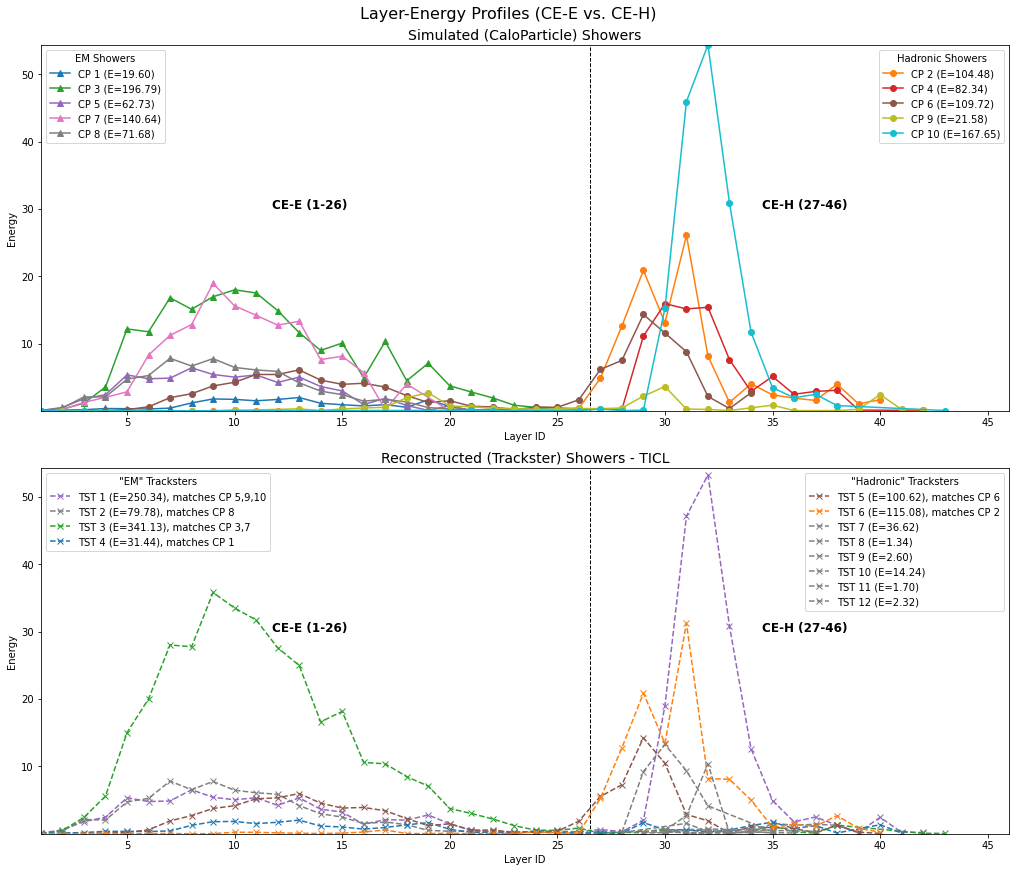

/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


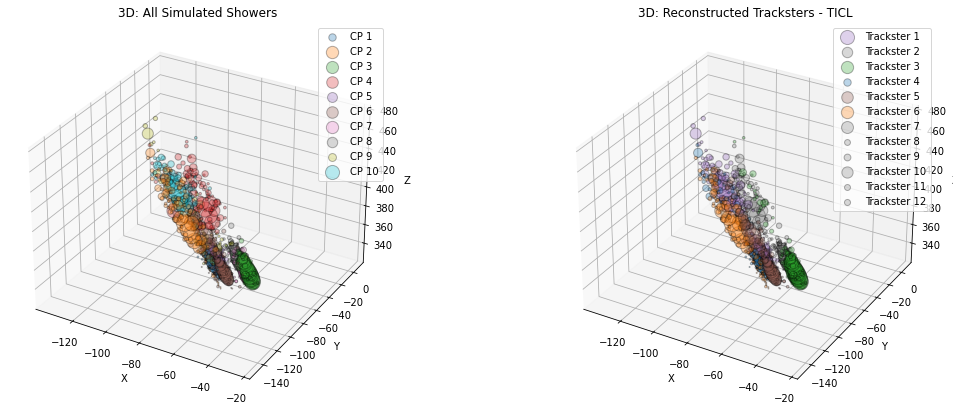

In [85]:
calculate_event_profile_data(GT_ind_filt, energies, MT_ind_filt, layer, GT_mult_filt, event_index=474)

In [119]:
print(len(recon_ind[474][8]))

2
